# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- nltk 3.7
- keras 2.9.0
- tensorflow 2.9.1


In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_20newsgroups

X_train_text, Y_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test_text, Y_test  = fetch_20newsgroups(subset="test", remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [2]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

classes = np.unique(Y_train)

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
# It's also possible to try with a stemmer or to mix a stemmer and a lemmatizer
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    text = ' '.join(words)
    return text

In [3]:
train_docs = []
test_docs = []

for raw_text in X_train_text:
    text = tokenize(raw_text)
    train_docs.append(text)
    
for raw_text in X_test_text:
    text = tokenize(raw_text)
    test_docs.append(text)
    

In [4]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_tokens = 50 ## Hyperparameter, input length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs+test_docs)

## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(train_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(test_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)


X_train_vect.shape, X_test_vect.shape

((11314, 50), (7532, 50))

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input

inputs = Input(shape=(max_tokens, ))
embeddings_layer = Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=50, input_length=max_tokens, trainable=True)
dense1 = Dense(128, activation="relu")
dense2 = Dense(64, activation="relu")
dense3 = Dense(len(classes), activation="softmax")

x = embeddings_layer(inputs)
x = tf.reduce_mean(x, axis=1) 
x = dense1(x)
x = dense2(x)
outputs = dense3(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            4753900   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 50)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                             

In [6]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [8]:
model.fit(X_train_vect, Y_train, batch_size=32, epochs=20, callbacks=[callback])

Epoch 1/20
354/354 [==============================] - 7s 19ms/step - loss: 2.5333 - accuracy: 0.2274
Epoch 2/20
354/354 [==============================] - 7s 20ms/step - loss: 1.2587 - accuracy: 0.6296
Epoch 3/20
354/354 [==============================] - 7s 19ms/step - loss: 0.6645 - accuracy: 0.8186
Epoch 4/20
354/354 [==============================] - 7s 19ms/step - loss: 0.3982 - accuracy: 0.8976
Epoch 5/20
354/354 [==============================] - 7s 19ms/step - loss: 0.2775 - accuracy: 0.9310
Epoch 6/20
354/354 [==============================] - 7s 19ms/step - loss: 0.2093 - accuracy: 0.9503
Epoch 7/20
354/354 [==============================] - 7s 19ms/step - loss: 0.1746 - accuracy: 0.9573
Epoch 8/20
354/354 [==============================] - 7s 19ms/step - loss: 0.1590 - accuracy: 0.9613
Epoch 9/20
354/354 [==============================] - 7s 19ms/step - loss: 0.1462 - accuracy: 0.9631
Epoch 10/20
354/354 [==============================] - 7s 19ms/step - loss: 0.1392 - accura

In [9]:
labels = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=labels))

236/236 [==============================] - 1s 2ms/step
Test Accuracy : 0.5003983005841742

Classification Report : 
                          precision    recall  f1-score   support

             alt.atheism       0.34      0.38      0.36       319
           comp.graphics       0.52      0.44      0.48       389
 comp.os.ms-windows.misc       0.29      0.58      0.38       394
comp.sys.ibm.pc.hardware       0.52      0.48      0.50       392
   comp.sys.mac.hardware       0.53      0.49      0.51       385
          comp.windows.x       0.68      0.53      0.60       395
            misc.forsale       0.59      0.68      0.63       390
               rec.autos       0.52      0.45      0.48       396
         rec.motorcycles       0.66      0.53      0.59       398
      rec.sport.baseball       0.69      0.62      0.65       397
        rec.sport.hockey       0.76      0.69      0.72       399
               sci.crypt       0.69      0.50      0.58       396
         sci.electronics 

In [11]:
import itertools, matplotlib.pyplot as plt, numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


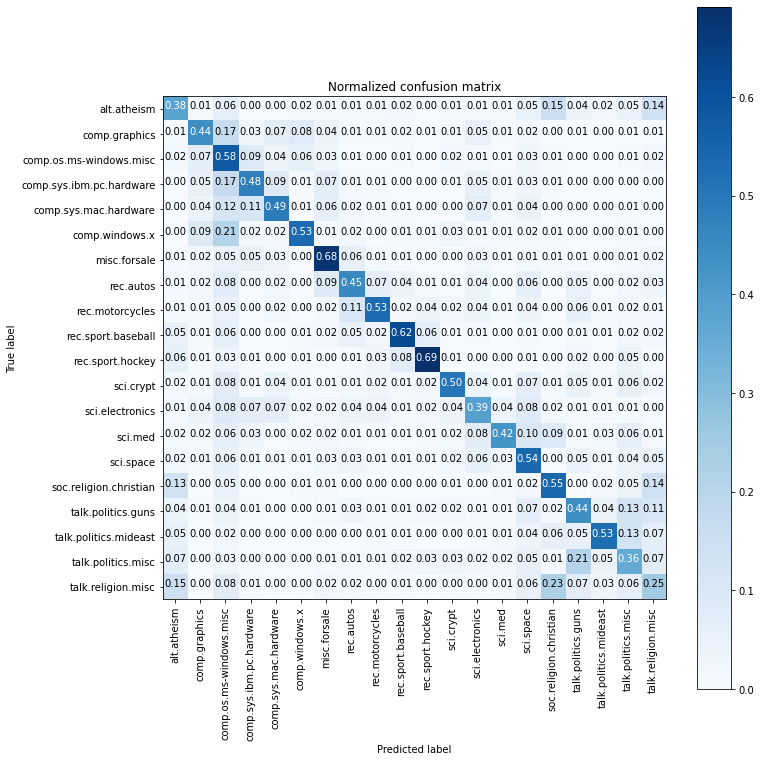

In [12]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(Y_test, Y_preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()